In [1]:
import copy
from functools import partial
import gc
from tensorflow import keras
from matplotlib import pyplot as plt
import numpy as np
from uncertainty_testbed.generators.data_generator_explicit import AnalyticBinaryClassGenerator
from uncertainty_testbed.utilities.functions import map_to_constant
from uncertainty_testbed.uncertainty_models.mc_dropout import MCDropoutLayer, MCDropoutKerasClassification

2022-05-01 00:39:20.734055: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-05-01 00:39:20.734083: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
# generate some data
s = partial(map_to_constant, c=0.01)
eg = AnalyticBinaryClassGenerator(seed=42, num_inputs=10, name="cauchy", threshold=0.5,
                                  noise_distribution="cauchy", noise_scale=s)
x, y = eg.generate_labeled(120096)
x = x.astype("float32")
y = y.astype("uint8")
x_train, y_train = x[:100096, :], y[:100096]
x_val, y_val = x[100096:, :], y[100096:]

In [3]:
def opt_name(optimizer):
    return str(optimizer).split("object")[0].split(".")[-1].strip().lower()

optimizer_lookup = {
    opt_name(opt): opt for opt in  
    [keras.optimizers.Nadam(learning_rate=3e-5), 
     keras.optimizers.SGD(learning_rate=5e-3), 
     keras.optimizers.RMSprop(learning_rate=5e-3),
     keras.optimizers.Adam(learning_rate=3e-3),
     keras.optimizers.Adadelta(learning_rate=1e-1),
     keras.optimizers.Adamax(learning_rate=7e-3)]
}

optimal_schedules = [
    {
        "optimizer": keras.optimizers.Nadam(learning_rate=3e-5),
        "learning_rate": 3e-5,
        "batch": 256,
        "epoch": 28
    },
    {
        "optimizer": keras.optimizers.SGD(learning_rate=5e-3),
        "learning_rate": 5e-3,
        "batch": 256,
        "epoch": 59
    },
    {
        "optimizer": keras.optimizers.SGD(learning_rate=1e-2),
        "learning_rate" :1e-2,
        "batch": 8,
        "epoch": 1
    },
    {
        "optimizer": keras.optimizers.RMSprop(learning_rate=5e-3),
        "learning_rate": 5e-3,
        "batch": 8,
        "epoch": 1# 0.1781
    },
    {
        "optimizer": keras.optimizers.Adam(learning_rate=3e-3),
        "learning_rate": 3e-3,
        "batch": 8,
        "epoch": 1# 0.2076
    },
    {
        "optimizer": keras.optimizers.Adadelta(learning_rate=1e-1),
        "learning_rate": 1e-1,
        "batch": 8,
        "epoch": 2# 0.2354
    },
    {
        "optimizer": keras.optimizers.Adamax(learning_rate=7e-3),
        "learning_rate": 7e-3,
        "batch": 8,
        "epoch": 1# 0.2249
    },
    {
        "optimizer": keras.optimizers.Nadam(learning_rate=7e-3),
        "learning_rate": 7e-3,
        "batch": 8,
        "epoch": 4# 0.1905
    }
]

In [4]:
scan_results = []
champion_params = None
champion_loss = np.inf
for params in optimal_schedules:
    lr = params["learning_rate"]
    for learning_rate in [0.8*lr, lr, 1.2*lr]:
        optimizer = params["optimizer"]
        optimizer.learning_rate.assign(learning_rate)
        num_epochs = int(1.4*params["epoch"] + 2)
        batch_size = int(params["batch"])
        model = keras.Sequential()
        model.add(keras.layers.Dense(60, activation="relu"))
        model.add(keras.layers.Dropout(0.25))
        model.add(keras.layers.Dense(60, activation="relu"))
        model.add(keras.layers.Dropout(0.25))
        model.add(keras.layers.Dense(60, activation="relu"))
        model.add(keras.layers.Dropout(0.25))
        model.add(keras.layers.Dense(1, activation="sigmoid"))
        model.compile(
            optimizer=optimizer,
            loss="binary_crossentropy",
            metrics=["accuracy", "AUC"]
        )
        history = model.fit(
            x_train,
            y_train,
            epochs=num_epochs,
            batch_size=batch_size,
            validation_data=(x_val, y_val),
        )
        
        history_dict = history.history
        val_loss = history_dict["val_loss"]
        val_auc = history_dict["val_auc"]
        val_accuracy = history_dict["val_accuracy"]
        epochs = range(1, len(val_loss)+1)
        
        best_loss = {"loss": val_loss[np.argmin(val_loss)], "epoch": epochs[np.argmin(val_loss)]}
        best_auc = {"auc": val_auc[np.argmax(val_auc)], "epoch": epochs[np.argmax(val_auc)]}
        best_accuracy = {"accuracy": val_accuracy[np.argmax(val_accuracy)], "epoch": epochs[np.argmax(val_accuracy)]}
        
        ps = {k: copy.deepcopy(v) for k, v in params.items() if k not in ["optimizer", "model"]}
        ps["optimizer"] = opt_name(optimizer)
        ps["learning_rate"] = copy.deepcopy(learning_rate)
        ps["best_loss"] = best_loss
        ps["best_auc"] = best_auc
        ps["best_accuracy"] = best_accuracy
        print(ps)
        scan_results.append(ps)
        
        if best_loss["loss"] < champion_loss:
            champion_loss = best_loss["loss"]
            champion_params = {k: copy.deepcopy(v) for k, v in ps.items()}
            champion_params["model"] = keras.models.clone_model(model)
        

model = keras.models.clone_model(champion_params["model"])

Epoch 1/41


2022-05-01 00:39:24.521674: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-05-01 00:39:24.521711: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-05-01 00:39:24.521735: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (xps): /proc/driver/nvidia/version does not exist
2022-05-01 00:39:24.521999: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


391/391 [==============================] - 2s 4ms/step - loss: 0.7006 - accuracy: 0.5013 - auc: 0.5021 - val_loss: 0.6900 - val_accuracy: 0.5436 - val_auc: 0.5561
Epoch 2/41
391/391 [==============================] - 1s 3ms/step - loss: 0.6940 - accuracy: 0.5185 - auc: 0.5267 - val_loss: 0.6835 - val_accuracy: 0.5881 - val_auc: 0.6220
Epoch 3/41
391/391 [==============================] - 1s 3ms/step - loss: 0.6872 - accuracy: 0.5390 - auc: 0.5583 - val_loss: 0.6756 - val_accuracy: 0.6171 - val_auc: 0.6642
Epoch 4/41
391/391 [==============================] - 1s 3ms/step - loss: 0.6801 - accuracy: 0.5586 - auc: 0.5867 - val_loss: 0.6651 - val_accuracy: 0.6418 - val_auc: 0.6995
Epoch 5/41
391/391 [==============================] - 1s 3ms/step - loss: 0.6710 - accuracy: 0.5815 - auc: 0.6186 - val_loss: 0.6510 - val_accuracy: 0.6701 - val_auc: 0.7378
Epoch 6/41
391/391 [==============================] - 1s 3ms/step - loss: 0.6592 - accuracy: 0.6031 - auc: 0.6488 - val_loss: 0.6316 - val_ac

391/391 [==============================] - 1s 3ms/step - loss: 0.5405 - accuracy: 0.7299 - auc: 0.8141 - val_loss: 0.4378 - val_accuracy: 0.8688 - val_auc: 0.9501
Epoch 6/41
391/391 [==============================] - 1s 3ms/step - loss: 0.4997 - accuracy: 0.7554 - auc: 0.8431 - val_loss: 0.3833 - val_accuracy: 0.8914 - val_auc: 0.9639
Epoch 7/41
391/391 [==============================] - 1s 3ms/step - loss: 0.4636 - accuracy: 0.7766 - auc: 0.8664 - val_loss: 0.3393 - val_accuracy: 0.9093 - val_auc: 0.9724
Epoch 8/41
391/391 [==============================] - 1s 3ms/step - loss: 0.4356 - accuracy: 0.7936 - auc: 0.8825 - val_loss: 0.3060 - val_accuracy: 0.9204 - val_auc: 0.9780
Epoch 9/41
391/391 [==============================] - 1s 3ms/step - loss: 0.4122 - accuracy: 0.8079 - auc: 0.8954 - val_loss: 0.2801 - val_accuracy: 0.9284 - val_auc: 0.9816
Epoch 10/41
391/391 [==============================] - 1s 3ms/step - loss: 0.3934 - accuracy: 0.8179 - auc: 0.9051 - val_loss: 0.2595 - val_a

391/391 [==============================] - 1s 3ms/step - loss: 0.3889 - accuracy: 0.8229 - auc: 0.9079 - val_loss: 0.2595 - val_accuracy: 0.9204 - val_auc: 0.9790
Epoch 10/41
391/391 [==============================] - 1s 3ms/step - loss: 0.3709 - accuracy: 0.8331 - auc: 0.9167 - val_loss: 0.2397 - val_accuracy: 0.9327 - val_auc: 0.9832
Epoch 11/41
391/391 [==============================] - 1s 3ms/step - loss: 0.3563 - accuracy: 0.8413 - auc: 0.9235 - val_loss: 0.2244 - val_accuracy: 0.9399 - val_auc: 0.9858
Epoch 12/41
391/391 [==============================] - 1s 3ms/step - loss: 0.3444 - accuracy: 0.8472 - auc: 0.9286 - val_loss: 0.2119 - val_accuracy: 0.9448 - val_auc: 0.9878
Epoch 13/41
391/391 [==============================] - 1s 3ms/step - loss: 0.3319 - accuracy: 0.8564 - auc: 0.9342 - val_loss: 0.2023 - val_accuracy: 0.9491 - val_auc: 0.9888
Epoch 14/41
391/391 [==============================] - 1s 3ms/step - loss: 0.3222 - accuracy: 0.8616 - auc: 0.9381 - val_loss: 0.1939 - v

391/391 [==============================] - 1s 3ms/step - loss: 0.5384 - accuracy: 0.7299 - auc: 0.8127 - val_loss: 0.4410 - val_accuracy: 0.8917 - val_auc: 0.9642
Epoch 14/84
391/391 [==============================] - 1s 3ms/step - loss: 0.5133 - accuracy: 0.7489 - auc: 0.8329 - val_loss: 0.4035 - val_accuracy: 0.9075 - val_auc: 0.9727
Epoch 15/84
391/391 [==============================] - 1s 3ms/step - loss: 0.4894 - accuracy: 0.7624 - auc: 0.8490 - val_loss: 0.3696 - val_accuracy: 0.9208 - val_auc: 0.9785
Epoch 16/84
391/391 [==============================] - 1s 3ms/step - loss: 0.4683 - accuracy: 0.7780 - auc: 0.8631 - val_loss: 0.3403 - val_accuracy: 0.9293 - val_auc: 0.9819
Epoch 17/84
391/391 [==============================] - 1s 3ms/step - loss: 0.4488 - accuracy: 0.7898 - auc: 0.8753 - val_loss: 0.3154 - val_accuracy: 0.9349 - val_auc: 0.9844
Epoch 18/84
391/391 [==============================] - 1s 3ms/step - loss: 0.4310 - accuracy: 0.8031 - auc: 0.8863 - val_loss: 0.2948 - v

Epoch 60/84
391/391 [==============================] - 1s 3ms/step - loss: 0.2249 - accuracy: 0.9155 - auc: 0.9703 - val_loss: 0.1309 - val_accuracy: 0.9740 - val_auc: 0.9939
Epoch 61/84
391/391 [==============================] - 1s 3ms/step - loss: 0.2211 - accuracy: 0.9171 - auc: 0.9713 - val_loss: 0.1297 - val_accuracy: 0.9747 - val_auc: 0.9940
Epoch 62/84
391/391 [==============================] - 1s 3ms/step - loss: 0.2190 - accuracy: 0.9190 - auc: 0.9717 - val_loss: 0.1288 - val_accuracy: 0.9747 - val_auc: 0.9940
Epoch 63/84
391/391 [==============================] - 1s 3ms/step - loss: 0.2166 - accuracy: 0.9206 - auc: 0.9725 - val_loss: 0.1279 - val_accuracy: 0.9750 - val_auc: 0.9940
Epoch 64/84
391/391 [==============================] - 1s 3ms/step - loss: 0.2159 - accuracy: 0.9202 - auc: 0.9724 - val_loss: 0.1269 - val_accuracy: 0.9750 - val_auc: 0.9941
Epoch 65/84
391/391 [==============================] - 1s 3ms/step - loss: 0.2158 - accuracy: 0.9192 - auc: 0.9724 - val_loss

391/391 [==============================] - 2s 5ms/step - loss: 0.3344 - accuracy: 0.8610 - auc: 0.9339 - val_loss: 0.1962 - val_accuracy: 0.9643 - val_auc: 0.9923
Epoch 22/84
391/391 [==============================] - 2s 5ms/step - loss: 0.3276 - accuracy: 0.8659 - auc: 0.9369 - val_loss: 0.1902 - val_accuracy: 0.9643 - val_auc: 0.9925
Epoch 23/84
391/391 [==============================] - 2s 5ms/step - loss: 0.3203 - accuracy: 0.8687 - auc: 0.9396 - val_loss: 0.1856 - val_accuracy: 0.9642 - val_auc: 0.9925
Epoch 24/84
391/391 [==============================] - 2s 5ms/step - loss: 0.3182 - accuracy: 0.8701 - auc: 0.9406 - val_loss: 0.1819 - val_accuracy: 0.9645 - val_auc: 0.9925
Epoch 25/84
391/391 [==============================] - 2s 5ms/step - loss: 0.3098 - accuracy: 0.8753 - auc: 0.9438 - val_loss: 0.1785 - val_accuracy: 0.9635 - val_auc: 0.9925
Epoch 26/84
391/391 [==============================] - 2s 5ms/step - loss: 0.3069 - accuracy: 0.8770 - auc: 0.9448 - val_loss: 0.1754 - v

Epoch 68/84
391/391 [==============================] - 2s 4ms/step - loss: 0.1952 - accuracy: 0.9254 - auc: 0.9775 - val_loss: 0.1195 - val_accuracy: 0.9780 - val_auc: 0.9947
Epoch 69/84
391/391 [==============================] - 2s 4ms/step - loss: 0.1948 - accuracy: 0.9265 - auc: 0.9776 - val_loss: 0.1193 - val_accuracy: 0.9780 - val_auc: 0.9947
Epoch 70/84
391/391 [==============================] - 2s 4ms/step - loss: 0.1950 - accuracy: 0.9256 - auc: 0.9775 - val_loss: 0.1190 - val_accuracy: 0.9782 - val_auc: 0.9947
Epoch 71/84
391/391 [==============================] - 2s 4ms/step - loss: 0.1920 - accuracy: 0.9273 - auc: 0.9782 - val_loss: 0.1185 - val_accuracy: 0.9786 - val_auc: 0.9947
Epoch 72/84
391/391 [==============================] - 2s 4ms/step - loss: 0.1898 - accuracy: 0.9283 - auc: 0.9786 - val_loss: 0.1180 - val_accuracy: 0.9782 - val_auc: 0.9947
Epoch 73/84
391/391 [==============================] - 2s 4ms/step - loss: 0.1904 - accuracy: 0.9279 - auc: 0.9786 - val_loss

391/391 [==============================] - 1s 2ms/step - loss: 0.2642 - accuracy: 0.8992 - auc: 0.9596 - val_loss: 0.1495 - val_accuracy: 0.9717 - val_auc: 0.9935
Epoch 30/84
391/391 [==============================] - 1s 2ms/step - loss: 0.2587 - accuracy: 0.9028 - auc: 0.9615 - val_loss: 0.1464 - val_accuracy: 0.9722 - val_auc: 0.9936
Epoch 31/84
391/391 [==============================] - 1s 2ms/step - loss: 0.2544 - accuracy: 0.9055 - auc: 0.9627 - val_loss: 0.1438 - val_accuracy: 0.9739 - val_auc: 0.9937
Epoch 32/84
391/391 [==============================] - 1s 2ms/step - loss: 0.2503 - accuracy: 0.9076 - auc: 0.9638 - val_loss: 0.1417 - val_accuracy: 0.9732 - val_auc: 0.9936
Epoch 33/84
391/391 [==============================] - 1s 2ms/step - loss: 0.2449 - accuracy: 0.9087 - auc: 0.9653 - val_loss: 0.1394 - val_accuracy: 0.9738 - val_auc: 0.9937
Epoch 34/84
391/391 [==============================] - 1s 2ms/step - loss: 0.2390 - accuracy: 0.9124 - auc: 0.9670 - val_loss: 0.1365 - v

Epoch 76/84
391/391 [==============================] - 1s 2ms/step - loss: 0.1438 - accuracy: 0.9517 - auc: 0.9872 - val_loss: 0.0863 - val_accuracy: 0.9852 - val_auc: 0.9949
Epoch 77/84
391/391 [==============================] - 1s 2ms/step - loss: 0.1425 - accuracy: 0.9526 - auc: 0.9872 - val_loss: 0.0858 - val_accuracy: 0.9859 - val_auc: 0.9949
Epoch 78/84
391/391 [==============================] - 1s 2ms/step - loss: 0.1410 - accuracy: 0.9529 - auc: 0.9876 - val_loss: 0.0851 - val_accuracy: 0.9854 - val_auc: 0.9949
Epoch 79/84
391/391 [==============================] - 1s 2ms/step - loss: 0.1408 - accuracy: 0.9533 - auc: 0.9876 - val_loss: 0.0846 - val_accuracy: 0.9861 - val_auc: 0.9950
Epoch 80/84
391/391 [==============================] - 1s 2ms/step - loss: 0.1394 - accuracy: 0.9525 - auc: 0.9878 - val_loss: 0.0840 - val_accuracy: 0.9863 - val_auc: 0.9950
Epoch 81/84
391/391 [==============================] - 1s 2ms/step - loss: 0.1375 - accuracy: 0.9537 - auc: 0.9881 - val_loss

Epoch 2/3
12512/12512 [==============================] - 21s 2ms/step - loss: 0.1349 - accuracy: 0.9538 - auc: 0.9880 - val_loss: 0.0949 - val_accuracy: 0.9673 - val_auc: 0.9931
Epoch 3/3
12512/12512 [==============================] - 21s 2ms/step - loss: 0.1209 - accuracy: 0.9604 - auc: 0.9898 - val_loss: 0.0922 - val_accuracy: 0.9721 - val_auc: 0.9942
{'learning_rate': 0.0036, 'batch': 8, 'epoch': 1, 'optimizer': 'adam', 'best_loss': {'loss': 0.09224160015583038, 'epoch': 3}, 'best_auc': {'auc': 0.9941719770431519, 'epoch': 3}, 'best_accuracy': {'accuracy': 0.9720500111579895, 'epoch': 3}}
Epoch 1/4
12512/12512 [==============================] - 20s 2ms/step - loss: 0.5739 - accuracy: 0.6765 - auc: 0.7619 - val_loss: 0.2913 - val_accuracy: 0.9061 - val_auc: 0.9726
Epoch 2/4
12512/12512 [==============================] - 19s 2ms/step - loss: 0.3399 - accuracy: 0.8514 - auc: 0.9307 - val_loss: 0.1669 - val_accuracy: 0.9581 - val_auc: 0.9909
Epoch 3/4
12512/12512 [======================

Epoch 6/7
12512/12512 [==============================] - 55s 4ms/step - loss: 0.1536 - accuracy: 0.9537 - auc: 0.9861 - val_loss: 0.0878 - val_accuracy: 0.9728 - val_auc: 0.9935
Epoch 7/7
12512/12512 [==============================] - 32s 3ms/step - loss: 0.1527 - accuracy: 0.9526 - auc: 0.9863 - val_loss: 0.1075 - val_accuracy: 0.9648 - val_auc: 0.9923
{'learning_rate': 0.007, 'batch': 8, 'epoch': 4, 'optimizer': 'nadam', 'best_loss': {'loss': 0.08782415091991425, 'epoch': 6}, 'best_auc': {'auc': 0.9934762716293335, 'epoch': 6}, 'best_accuracy': {'accuracy': 0.9727500081062317, 'epoch': 6}}
Epoch 1/7
12512/12512 [==============================] - 26s 2ms/step - loss: 0.2682 - accuracy: 0.8946 - auc: 0.9618 - val_loss: 0.1729 - val_accuracy: 0.9416 - val_auc: 0.9861
Epoch 2/7
12512/12512 [==============================] - 25s 2ms/step - loss: 0.2339 - accuracy: 0.9145 - auc: 0.9722 - val_loss: 0.1524 - val_accuracy: 0.9482 - val_auc: 0.9887
Epoch 3/7
12512/12512 [======================

In [5]:
optimizer = optimizer_lookup[champion_params["optimizer"]]
learning_rate = champion_params["learning_rate"]
optimizer.learning_rate.assign(learning_rate)
batch_size = champion_params["batch"]
num_epochs = champion_params["best_loss"]["epoch"]

# train a Keras MLP
model = keras.Sequential()
model.add(keras.layers.Dense(60, activation="relu"))
model.add(keras.layers.Dropout(0.25))
model.add(keras.layers.Dense(60, activation="relu"))
model.add(keras.layers.Dropout(0.25))
model.add(keras.layers.Dense(60, activation="relu"))
model.add(keras.layers.Dropout(0.25))
model.add(keras.layers.Dense(1, activation="sigmoid"))
model.compile(
    optimizer=optimizer,
    loss="binary_crossentropy",
    metrics=["accuracy", "AUC"]
)
history = model.fit(
    x_train,
    y_train,
    epochs=num_epochs,
    batch_size=batch_size,
    validation_data=(x_val, y_val)
)

Epoch 1/3
12512/12512 [==============================] - 24s 2ms/step - loss: 0.1792 - accuracy: 0.9282 - auc: 0.9807 - val_loss: 0.0711 - val_accuracy: 0.9791 - val_auc: 0.9948
Epoch 2/3
12512/12512 [==============================] - 47s 4ms/step - loss: 0.0928 - accuracy: 0.9701 - auc: 0.9929 - val_loss: 0.0654 - val_accuracy: 0.9801 - val_auc: 0.9954
Epoch 3/3
12512/12512 [==============================] - 35s 3ms/step - loss: 0.0840 - accuracy: 0.9731 - auc: 0.9936 - val_loss: 0.0637 - val_accuracy: 0.9819 - val_auc: 0.9957


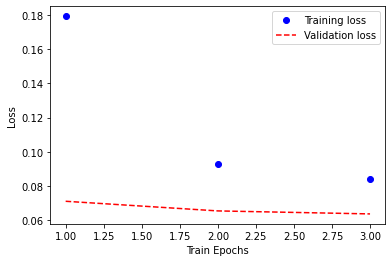

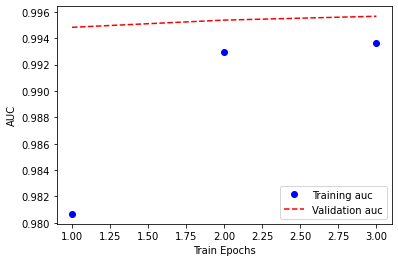

In [6]:
# inspect metrics
history_dict = history.history
loss = history_dict["loss"]
val_loss = history_dict["val_loss"]
auc = history_dict["auc"]
val_auc = history_dict["val_auc"]
epochs = range(1, len(loss)+1)

plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "r--", label="Validation loss")
plt.xlabel("Train Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

plt.plot(epochs, auc, "bo", label="Training auc")
plt.plot(epochs, val_auc, "r--", label="Validation auc")
plt.xlabel("Train Epochs")
plt.ylabel("AUC")
plt.legend()
plt.show()

In [7]:
n = 5
s = 100

p = model.predict(x_val[:1000,:])[:, 0]

scores = eg.get_scores(x_val[:1000,:])
ix_srt = np.argsort(scores)

probs = eg.get_probabilities(x_val[:1000,:])[1]

p = np.convolve(p[ix_srt[::-1]], np.ones(n)/n, mode='valid')
scores = np.convolve(scores[ix_srt[::-1]], np.ones(n)/n, mode='valid')
probs = np.convolve(probs[ix_srt[::-1]], np.ones(n)/n, mode='valid')

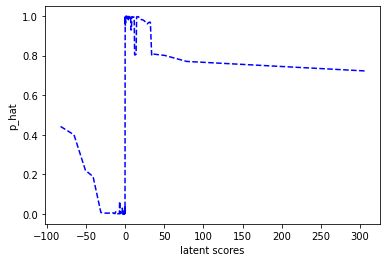

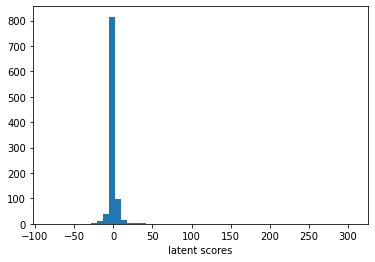

In [8]:
plt.plot(scores, p, '--b')
plt.xlabel('latent scores')
plt.ylabel('p_hat')
plt.show()

plt.hist(scores, bins=50)
plt.xlabel('latent scores')
plt.show()

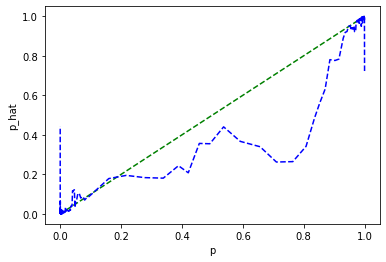

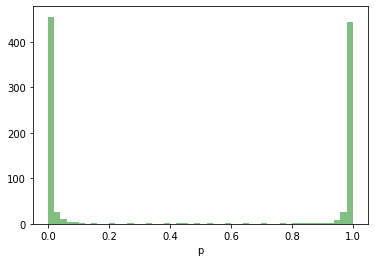

In [9]:
plt.plot(probs, probs, '--g')
plt.plot(probs, p, '--b')
plt.xlabel('p')
plt.ylabel('p_hat')
plt.show()

plt.hist(probs, bins=50, color='g', alpha=0.5)
plt.xlabel('p')
plt.show()

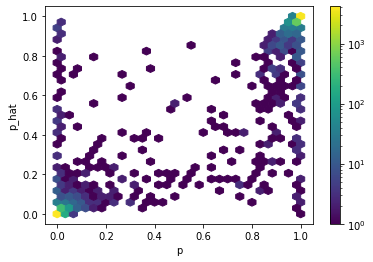

In [10]:
n = 1
s = 100

p = model.predict(x_val[:10000,:])[:, 0]

scores = eg.get_scores(x_val[:10000,:])

probs = eg.get_probabilities(x_val[:10000,:])[1]

plt.hexbin(probs, p, gridsize=30, bins='log')
plt.colorbar()
plt.xlabel('p')
plt.ylabel('p_hat')
plt.show()

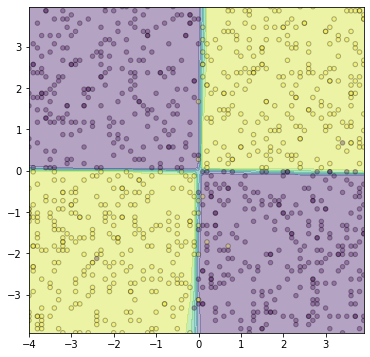

In [15]:
# Plot decision regions
I, J = 2, 6
x_min, x_max = x_val[:, I].min(), x_val[:, I].max()
y_min, y_max = x_val[:, J].min(), x_val[:, J].max()
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1), np.arange(y_min, y_max, 0.1))
xxyy = np.c_[xx.ravel(), yy.ravel()]
x_ = 0. * np.ones((xxyy.shape[0], 10))
x_[:, I] = xxyy[:, 0]
x_[:, J] = xxyy[:, 1]
z = model.predict(x_)
z = z.reshape(xx.shape)
y_ = eg.get_labels(x_)

fig = plt.figure(figsize=(6,6))
ax = fig.gca()
ax.contourf(xx, yy, z, alpha=0.4)
ixs = np.random.randint(0, y_.shape[0]-1, 1000)
ax.scatter(x_[ixs, I], x_[ixs, J], c=y_[ixs], s=20, alpha=0.3, edgecolor="k")
plt.show()

#model.summary()

In [12]:
model.summary()

Model: "sequential_24"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_96 (Dense)            (None, 60)                660       
                                                                 
 dropout_72 (Dropout)        (None, 60)                0         
                                                                 
 dense_97 (Dense)            (None, 60)                3660      
                                                                 
 dropout_73 (Dropout)        (None, 60)                0         
                                                                 
 dense_98 (Dense)            (None, 60)                3660      
                                                                 
 dropout_74 (Dropout)        (None, 60)                0         
                                                                 
 dense_99 (Dense)            (None, 1)               

In [13]:
champion_params

{'learning_rate': 0.005600000000000001,
 'batch': 8,
 'epoch': 1,
 'optimizer': 'adamax',
 'best_loss': {'loss': 0.061571039259433746, 'epoch': 3},
 'best_auc': {'auc': 0.9955193996429443, 'epoch': 2},
 'best_accuracy': {'accuracy': 0.9817500114440918, 'epoch': 3},
 'model': <keras.engine.sequential.Sequential at 0x7f7c02b26ee0>}

In [14]:
scan_results

[{'learning_rate': 2.4e-05,
  'batch': 256,
  'epoch': 28,
  'optimizer': 'nadam',
  'best_loss': {'loss': 0.15470701456069946, 'epoch': 41},
  'best_auc': {'auc': 0.9924156665802002, 'epoch': 41},
  'best_accuracy': {'accuracy': 0.9653000235557556, 'epoch': 41}},
 {'learning_rate': 3e-05,
  'batch': 256,
  'epoch': 28,
  'optimizer': 'nadam',
  'best_loss': {'loss': 0.1265670359134674, 'epoch': 41},
  'best_auc': {'auc': 0.9940298199653625, 'epoch': 41},
  'best_accuracy': {'accuracy': 0.9751999974250793, 'epoch': 40}},
 {'learning_rate': 3.6e-05,
  'batch': 256,
  'epoch': 28,
  'optimizer': 'nadam',
  'best_loss': {'loss': 0.11418497562408447, 'epoch': 41},
  'best_auc': {'auc': 0.9943035840988159, 'epoch': 41},
  'best_accuracy': {'accuracy': 0.9772999882698059, 'epoch': 40}},
 {'learning_rate': 0.004,
  'batch': 256,
  'epoch': 59,
  'optimizer': 'sgd',
  'best_loss': {'loss': 0.1122252568602562, 'epoch': 84},
  'best_auc': {'auc': 0.9946181178092957, 'epoch': 84},
  'best_accurac

### Tuning notes: 

Data: train 100096 / val 20000

--
* model: 30, 0.25, 30, 0.25, 30, 0.25, 30, 0.25, 1/ batch: 256 / Nadam lr: 3e-5
* Epoch: 80/80 **val_loss: 0.4221** - val_accuracy: 0.7657 - val_auc: 0.9857

--
* model: 30, 0.25, 30, 0.25, 30, 0.25, 1/ batch: 256 / Nadam lr: 3e-5
* Epoch: 60/80 **val_loss: 0.3241** - val_accuracy: 0.8463 - val_auc: 0.9856

--
* model: 40, 0.25, 40, 0.25, 40, 0.25, 1/ batch: 256 / Nadam lr: 3e-5
* Epoch: 40/80 **val_loss: 0.2726** - val_accuracy: 0.8848 - val_auc: 0.9889

--
* model: 50, 0.25, 50, 0.25, 50, 0.25, 1/ batch: 256 / Nadam lr: 3e-5
* Epoch: 38/80 **val_loss: 0.2555** - val_accuracy: 0.8832 - val_auc: 0.9916

--
* model: 60, 0.25, 60, 0.25, 60, 0.25, 1/ batch: 256 / Nadam lr: 3e-5
* Epoch: 28/80 **val_loss: 0.2552** - val_accuracy: 0.8909 - val_auc: 0.9929

--
* model: 60, 0.25, 60, 0.25, 60, 0.25, 1/ batch: 256 / Nadam lr: 2e-5
* Epoch: 48/80 **0.2557** - val_accuracy: 0.8771 - val_auc: 0.9935

--
* model: 60, 0.25, 60, 0.25, 60, 0.25, 20, 0.25, 6, 0.25, 1/ batch: 256 / Nadam lr: 2e-5
* Epoch: 47/80 **0.3482** - val_accuracy: 0.8346 - val_auc: 0.9910

--
* model: 60, 0.25, 60, 0.25, 60, 0.25, 1/ batch: 256 / SGD lr: 5e-3
* Epoch: 59/80 **0.2176** - val_accuracy: 0.8953 - val_auc: 0.9961

--
* model: 60, 0.25, 60, 0.25, 60, 0.25, 1/ batch: 256 / SGD lr: 3e-3
* Epoch: 80/100 **0.2205** - val_accuracy: 0.8970 - val_auc: 0.9951

--
8/1e-2=> 0.2021 - val_accuracy: 0.9207 - val_auc: 0.9904
8/8e-3=> 0.26...
8/1.3e-2=> 0.25